## Question #1
(50 points) Climo graph of maximum temperature and accumulated precipitation for San Fransisco, CA (`sfothr`), Chicago, IL (`ordthr`), and New York City, NY (`nycthr`).

Data Link: http://data.rcc-acis.org/StnData?sid=ordthr&sdate=por&edate=por&elems=mint,avgt,maxt,pcpn,snow,snwd&output=csv

Change the sid for each city...the above example is set for Chicago, IL with `sid=ordthr`.

For each city...
1. (5 points) Create a 30 year mean (using data from 1 January 1991 to 31 December 2020) for each day (using Pandas groupby method) for the maximum temperature and precipitation.
2. (5 points) Tansform the 30-year mean accumulated precipitation into a cumulative sum of precipitation (e.g., adding all of the previous days of the year precipitation to the current day so that at the last day of the year reflects the total accumulated precipitation for that time period).
3. (5 points) Subset and create a new variable that contains the temperature data for 2022.
4. (5 points) Subset and create a new variable that contains the acuumulated precipitation data for 2022.
5. (10 points) Plot the 30-year mean temperature average along with the data for 2022 on a single axes. Set your x-axis values to be Julian day of the year (e.g., 1-366, may need to be less for current year data)
6. (10 points) Plot the 30-year mean accumulated precipitation along with the data for 2022 on a second axes. Again set your x-axis values to be Julian day of the year (e.g., 1-366, may need to be less for current year data).
7. (10 points) Appropriately title, label, and have good plot aesthetics for your figure.
8. Save your figure with an appropriate name.

Notes:
* You should have three separate figures at the end, one for each city. Each figure should have two axes, one plotting temperature data, the other plotting precipitation data.
* Use appropriate colors for all plot characteristics.

# Assignment #6

This assignment can be completed by adding code to this notebook for each question.

Turn in a completed script, renamed as

`assignment6_lastname.ipynb`

via JupyterHub and Canvas. 

**DUE DATE: 4 November 2024 at 11 a.m.**

Prior to turning in your script, please cleanup and comment your code for each problem. Be sure that your output is self-describing.

In [1]:
#Importing packages
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Function to pull and clean data for each city
def fetch_city_df():
    
    # Dictionary of cities and IDs
    cities = {
        'San Francisco': 'sfothr',
        'Chicago': 'ordthr',
        'New York City': 'nycthr'
    }
    
    # Dictionary to store dataframes for each city
    city_data = {}

    # List of column headers
    col_names = ['date', 'minT', 'avgT', 'maxT', 'precip', 'snow', 'snowdepth']

    # Pulling and cleaning data for each city
    for city, sid in cities.items():
        url = f'http://data.rcc-acis.org/StnData?sid={sid}&sdate=por&edate=por&elems=mint,avgt,maxt,pcpn,snow,snwd&output=csv'
        city_data[city] = pd.read_csv(url, skiprows=1, na_values='M',names=col_names)

        # Converting 'date' column to datetime
        city_data[city]['date'] = pd.to_datetime(city_data[city]['date'])

        # Replacing 'T' with a trace numeric value and converting columns to float64
        for col in col_names[1:]:
            city_data[city][col] = city_data[city][col].replace('T', 0.0001).astype(np.float64)

    return city_data


# Function to calculate 1991-2020 daily mean for max temperature and precipitation
def calculate_30_year_mean(city_data):

    # Dictionary to store mean data
    mean_data = {}

    for city, df in city_data.items():
        
        # Filtering data for 1991–2020 period
        df_1991_2020 = df[(df['date'].dt.year >= 1991) & (df['date'].dt.year <= 2020)]

        # Removing leap day (February 29) for comparison to non leap year (2022)
        df_1991_2020 = df[(df['date'].dt.month != 2) | (df['date'].dt.day != 29)]


        # Grouping by month and day
        month_day = df_1991_2020.groupby([df_1991_2020['date'].dt.month, df_1991_2020['date'].dt.day])

        # Calculating mean for max temp and precip
        maxT_mean = month_day['maxT'].mean().round(2)
        precip_mean = month_day['precip'].mean().round(2)

        # Combining to single dataframe
        daily_means = pd.DataFrame({
            'maxT': maxT_mean,
            'precip': precip_mean    
        })

        mean_data[city] = daily_means

    return mean_data

# Function to calculate precip cumulative sum
def calculate_cumulative_precip(mean_data):
    
    # Dictionary for cumulative precip
    cumulative_data = {}

    for city, df in mean_data.items():
        # Calculating cumulative sum of daily mean precip
        df['cumulative_precip'] = df['precip'].cumsum()
        
        # Storing dataframe with cumulative precip
        cumulative_data[city] = df

    return cumulative_data

# Function to extract 2022 temperature data and calculate cumulative precip
def extract_2022_data(city_data):
    
    # Dictionary to store 2022 data for each city
    data_2022 = {}

    for city, df in city_data.items():
        # Filtering data for the year 2022
        df_2022 = df[df['date'].dt.year == 2022]


        # Calculating cumulative sum of daily mean precip and adding column to df
        df_2022 = df_2022.assign(cumulative_precip=df_2022['precip'].cumsum())

        df_2022['date'] = pd.to_datetime(
            {'year': 2022, 
             'month': df_2022['date'].dt.month, 
             'day': df_2022['date'].dt.day}
        )

        # Storing 2022 temperature and cumulative precip data
        data_2022[city] = df_2022[['date','minT', 'avgT', 'maxT', 'cumulative_precip']]

    return data_2022


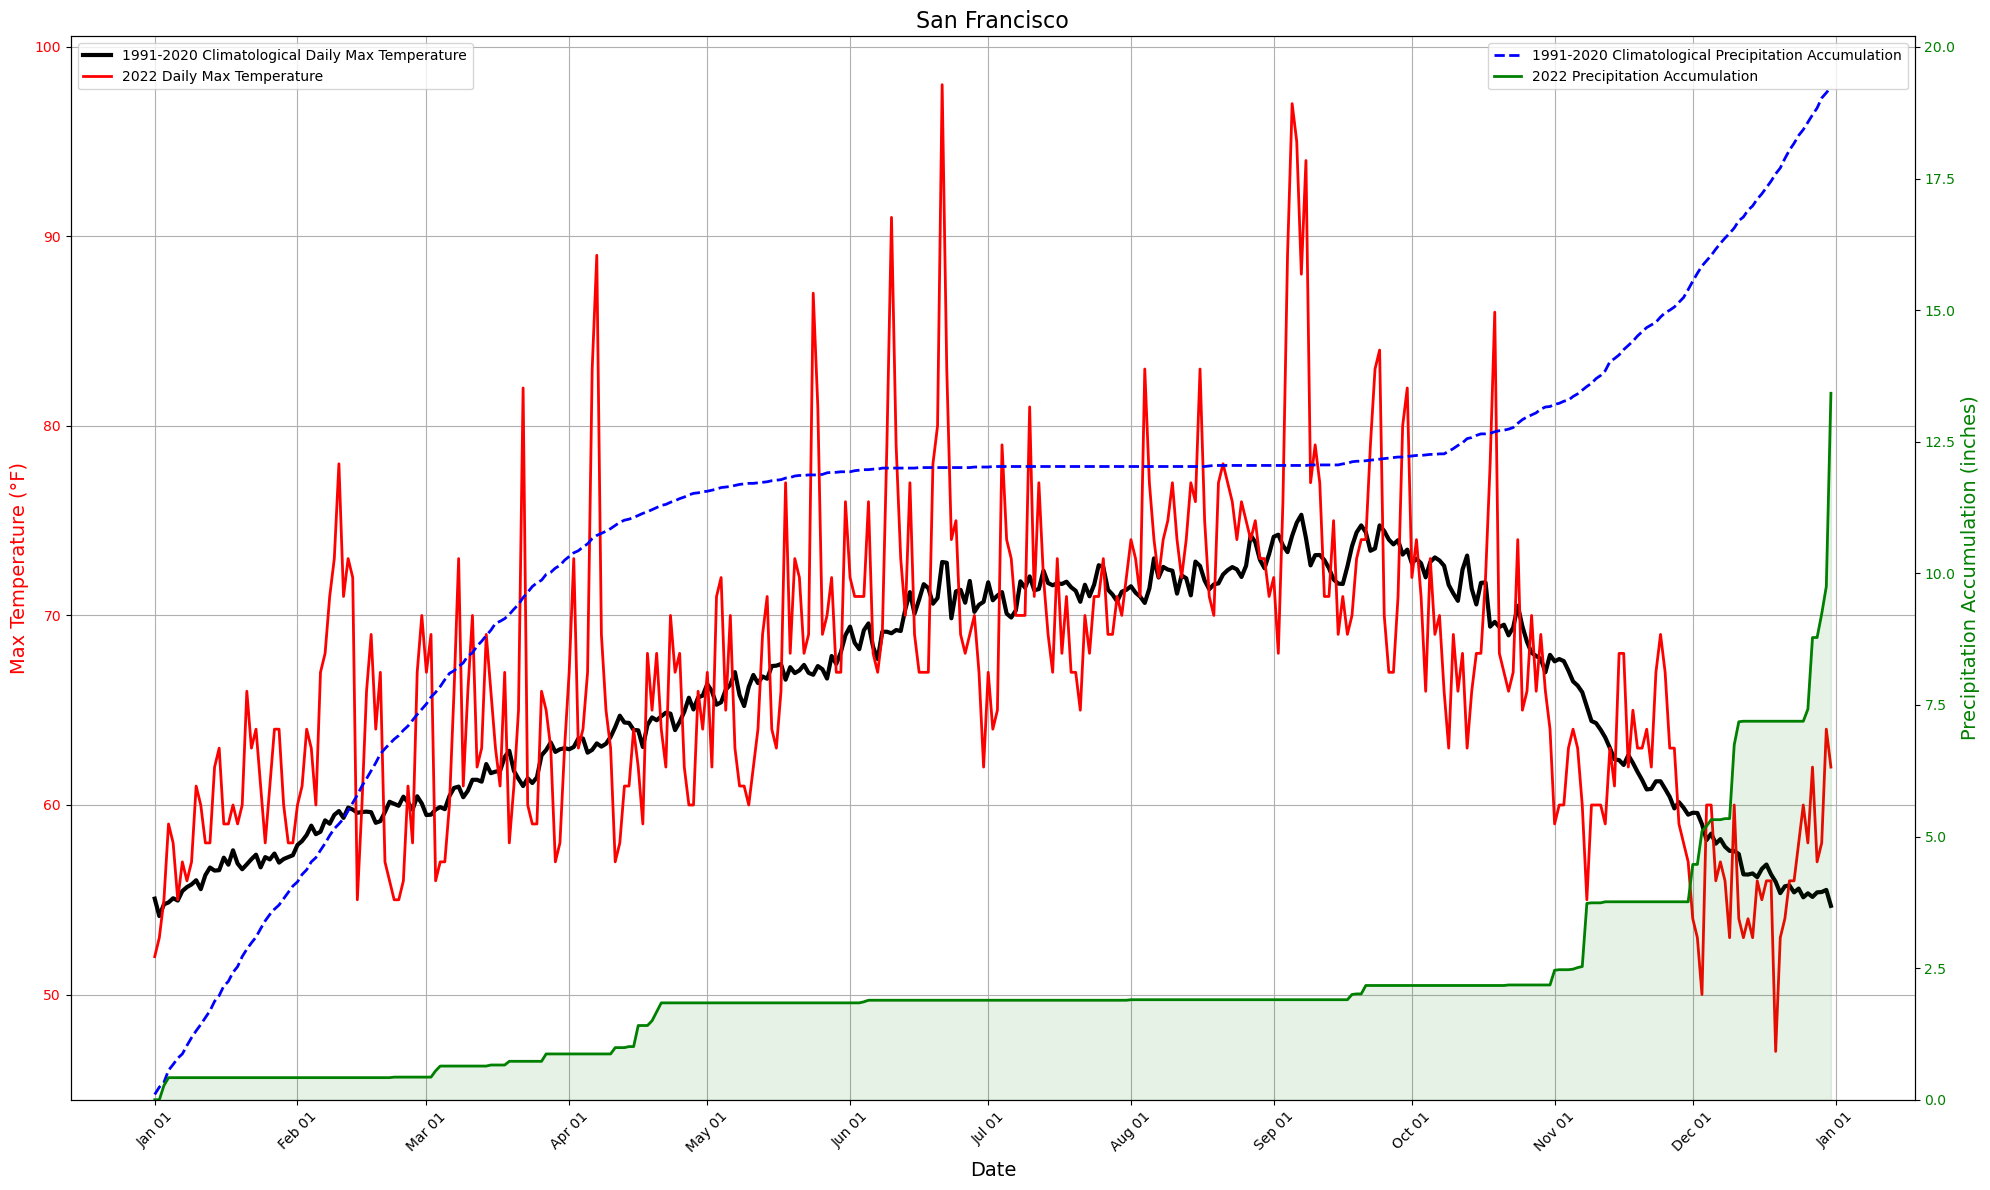

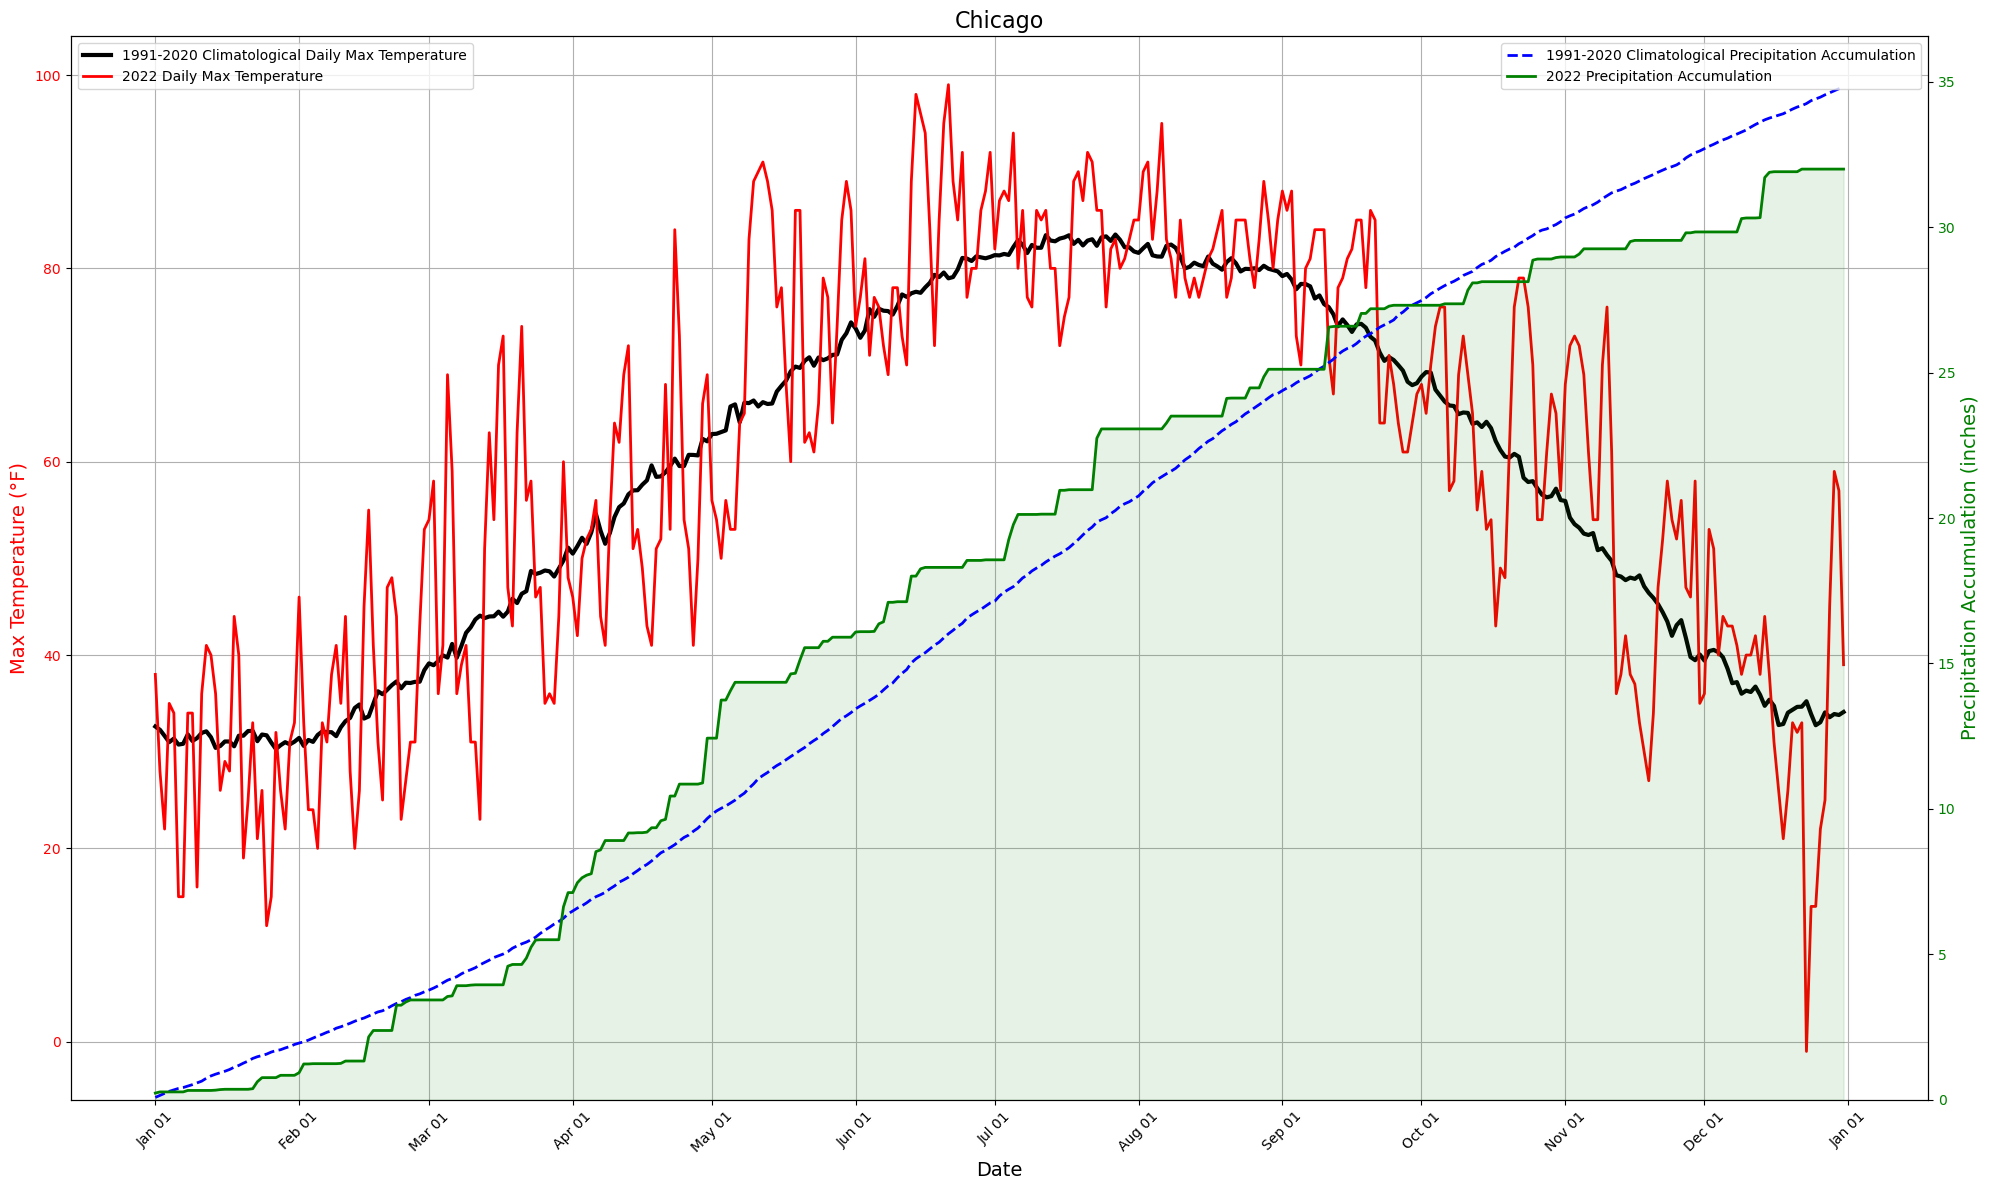

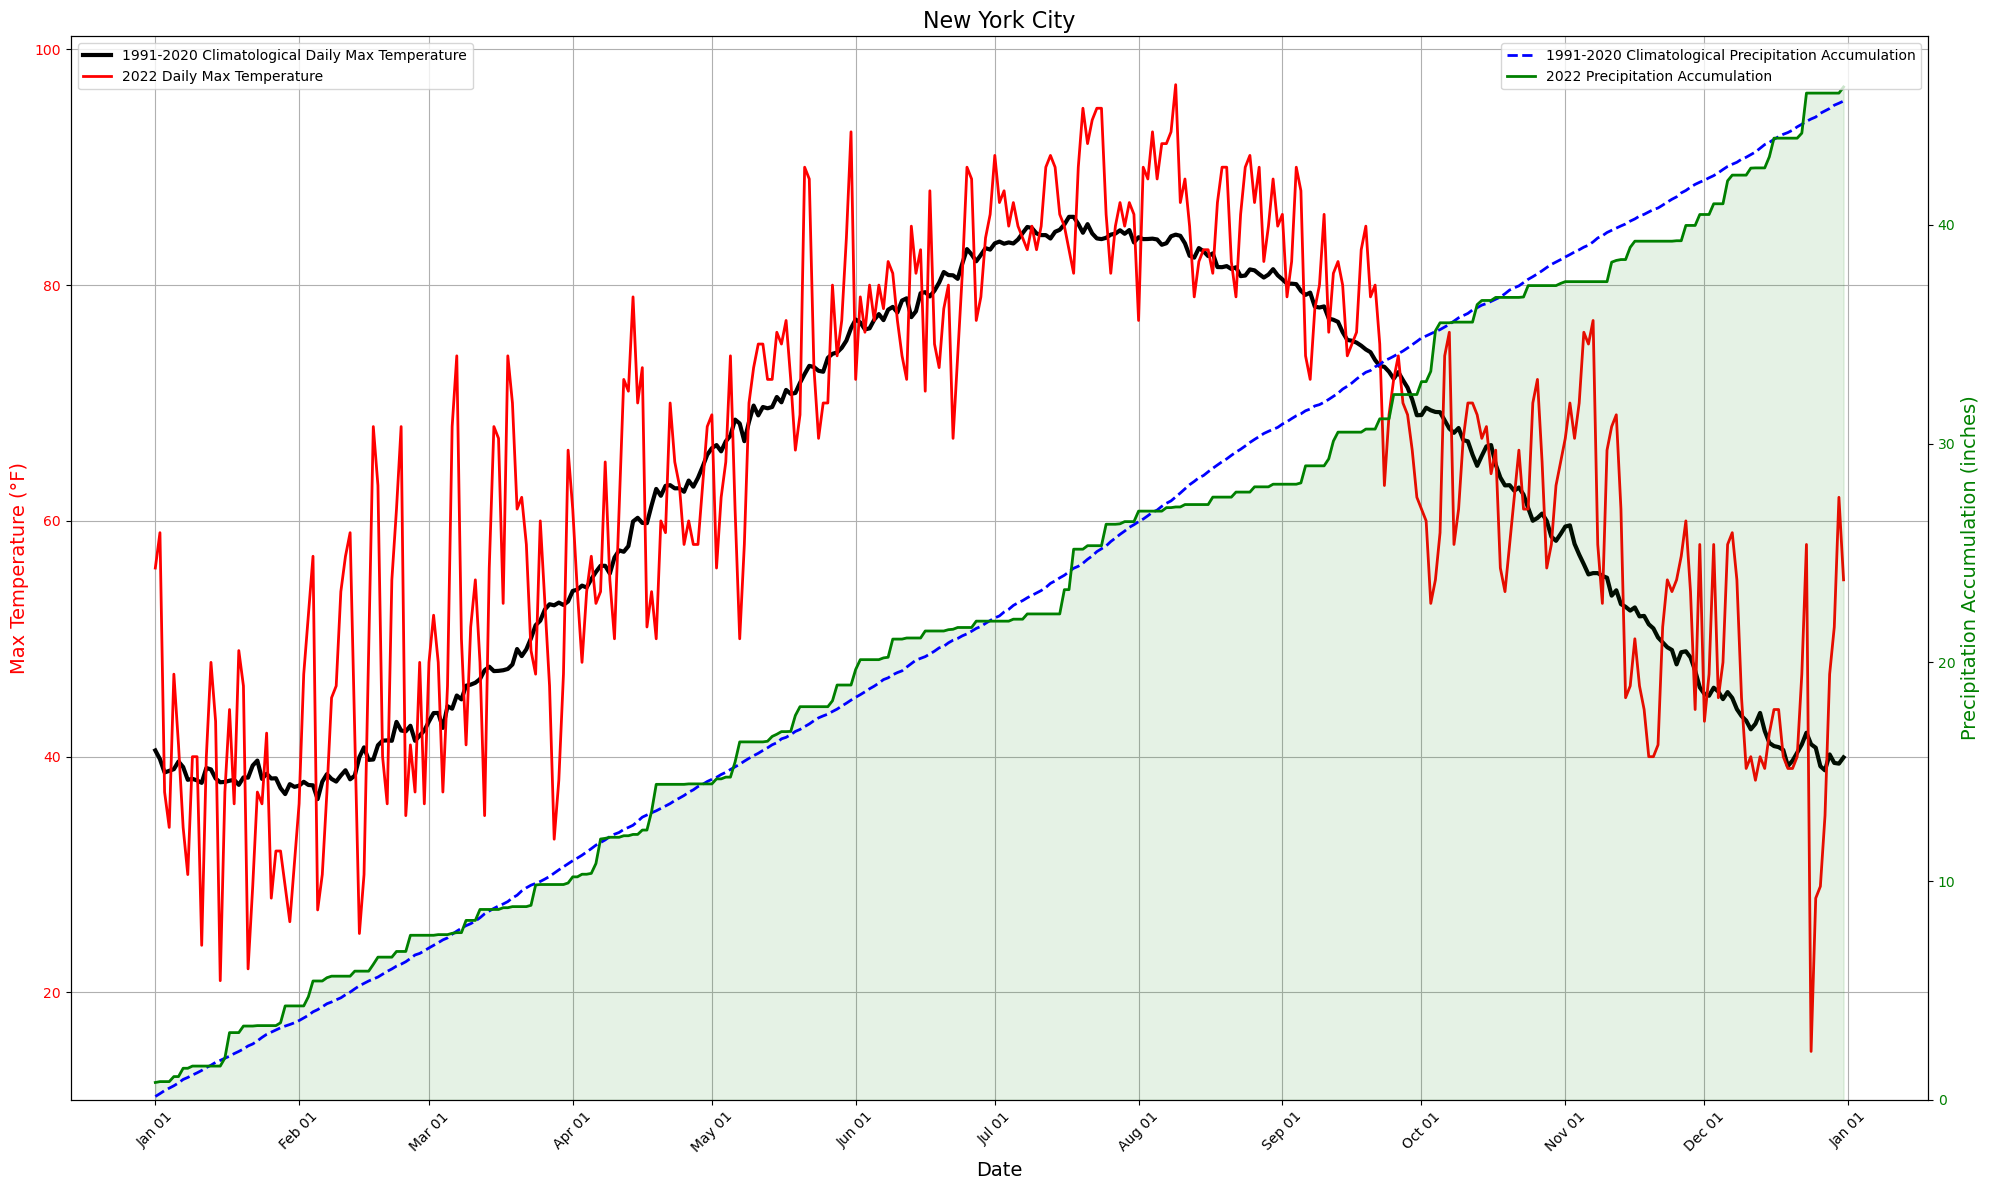

In [3]:
# Fetching data
city_data = fetch_city_df()

# Calculating 1991-2020 mean max temp and precip
mean_data = calculate_30_year_mean(city_data)

# Calculating 1991-2020 cumulative sum from daily mean precip
cumulative_precip = calculate_cumulative_precip(mean_data)

# Extracting 2022 temperature and cumulative precip data
temp_precip_data_2022 = extract_2022_data(city_data)

# List of cities
cities = ['San Francisco', 'Chicago', 'New York City']

# Plotting each city
for city in cities:
    # Creating figure
    fig, ax1 = plt.subplots(figsize=(20, 12))

    # Dates for mean x-axis to line up with 2022 data on plots
    mean_axis_dates = pd.to_datetime(
        {'year': 2022, 
         'month': mean_data[city].index.get_level_values(0), 
         'day': mean_data[city].index.get_level_values(1)}
    )

    # Plotting 1991-2020 climatological daily max temperature
    ax1.plot(mean_axis_dates, mean_data[city]['maxT'], linestyle='-', linewidth=3,
             color='black', label=f'1991-2020 Climatological Daily Max Temperature')
    
    # Plotting 2022 daily max temperature
    ax1.plot(mean_axis_dates, temp_precip_data_2022[city]['maxT'], linestyle='-', linewidth=2,
             color='red', label=f'2022 Daily Max Temperature')
    
    # Adding plot features
    ax1.set_title(f'{city}', fontsize=16)
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Max Temperature (°F)', color='red', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid()

    # Creating secondary y-axis for precipitation
    ax2 = ax1.twinx()
    
    # Plotting 1991-2020 climatological accumulated precipitation
    ax2.plot(temp_precip_data_2022[city]['date'], cumulative_precip[city]['cumulative_precip'],
             linestyle='--',  linewidth=2, color='blue', label=f'1991-2020 Climatological Precipitation Accumulation')
    
    # Plotting 2022 precipitation accumulation
    ax2.plot(temp_precip_data_2022[city]['date'], temp_precip_data_2022[city]['cumulative_precip'],
             linestyle='-', linewidth=2, color='green', label=f'2022 Precipitation Accumulation')
    
    # Shading area under 2022 precipitation accumulation curve
    ax2.fill_between(temp_precip_data_2022[city]['date'], 0, temp_precip_data_2022[city]['cumulative_precip'], color='green', alpha=0.1)

    # Adding plot features
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('Precipitation Accumulation (inches)', color='green', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    # Formatting date on x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    # Saving plots
    plt.tight_layout()
    plt.savefig(f'{city}_max_temp_precip_accum')
    plt.show()
